In [275]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostRegressor, Pool
import optuna

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

### Datasets:

https://data.open-power-system-data.org/

time_series_60min_singleindex.csv ---> data about production of solar and wind stations

weather_data_GER_2016.csv ---> weather

### Read data:

In [276]:
production_wind_solar = pd.read_csv("../data/time_series_60min_singleindex.csv",
                        usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                        parse_dates=[0], index_col=0)

production_wind_solar = production_wind_solar.loc[production_wind_solar.index.year == 2016, :][['DE_wind_generation_actual', 'DE_solar_generation_actual']]
production_wind_solar.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2016-01-01 00:00:00+00:00,8579.0,0.0
2016-01-01 01:00:00+00:00,8542.0,0.0
2016-01-01 02:00:00+00:00,8443.0,0.0
2016-01-01 03:00:00+00:00,8295.0,0.0
2016-01-01 04:00:00+00:00,7319.0,0.0


In [277]:
output.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 23:00:00+00:00
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DE_wind_generation_actual   8710 non-null   float64
 1   DE_solar_generation_actual  8712 non-null   float64
dtypes: float64(2)
memory usage: 205.9 KB


In [278]:
weather = pd.read_csv("../data/weather_data_GER_2016.csv",
                     parse_dates=[0], index_col=0)
weather_by_day = weather.groupby(weather.index).mean()
weather_by_day.head()

,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.0,51.25,10.3125,2.616758,3.714414,5.132500,2.546875,10.546875,0.164370,0.0,0.0,275.296747,1.253185,99281.007812
2016-01-01 01:00:00+00:00,1.0,51.25,10.3125,2.564375,3.631055,4.976094,2.546875,10.546875,0.164331,0.0,0.0,275.255473,1.253778,99288.492188
2016-01-01 02:00:00+00:00,2.0,51.25,10.3125,2.480859,3.516328,4.794688,2.546875,10.546875,0.164288,0.0,0.0,275.217089,1.254304,99296.398438
2016-01-01 03:00:00+00:00,3.0,51.25,10.3125,2.397148,3.404961,4.664023,2.546875,10.546875,0.164239,0.0,0.0,275.211715,1.254562,99306.695312
2016-01-01 04:00:00+00:00,4.0,51.25,10.3125,2.305703,3.286602,4.566289,2.546875,10.546875,0.164199,0.0,0.0,275.193369,1.254733,99319.750000


* wind
    - v1: velocity [m/s] @ height h1 (2 meters above displacement height)
    - v2: velocity [m/s] @ height h2 (10 meters above displacement height)
    - v_50m: velocity [m/s] @ 50 meters above ground
    - h1: height above ground [m] (h1 = displacement height +2m)
    - h2: height above ground [m] (h2 = displacement height +10m)
    - z0: roughness length [m]
* solar parameters:
    - SWTDN: total top-of-the-atmosphere horizontal radiation [W/m²]
    - SWGDN: total ground horizontal radiation [W/m²]
* temperature data
    - T: Temperature [K] @ 2 meters above displacement height (see h1)
* air data
    - Rho: air density [kg/m³] @ surface
    - p: air pressure [Pa] @ surface

### Join datasets:

In [279]:
# merge production_wind_solar and weather_by_day DataFrames
df = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)
df.head()

,DE_wind_generation_actual,DE_solar_generation_actual,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
utc_timestamp,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,8579.0,0.0,0.0,51.25,10.3125,2.616758,3.714414,5.132500,2.546875,10.546875,0.164370,0.0,0.0,275.296747,1.253185,99281.007812
2016-01-01 01:00:00+00:00,8542.0,0.0,1.0,51.25,10.3125,2.564375,3.631055,4.976094,2.546875,10.546875,0.164331,0.0,0.0,275.255473,1.253778,99288.492188
2016-01-01 02:00:00+00:00,8443.0,0.0,2.0,51.25,10.3125,2.480859,3.516328,4.794688,2.546875,10.546875,0.164288,0.0,0.0,275.217089,1.254304,99296.398438
2016-01-01 03:00:00+00:00,8295.0,0.0,3.0,51.25,10.3125,2.397148,3.404961,4.664023,2.546875,10.546875,0.164239,0.0,0.0,275.211715,1.254562,99306.695312
2016-01-01 04:00:00+00:00,7319.0,0.0,4.0,51.25,10.3125,2.305703,3.286602,4.566289,2.546875,10.546875,0.164199,0.0,0.0,275.193369,1.254733,99319.750000


In [307]:
df.columns

Index(['DE_wind_generation_actual', 'DE_solar_generation_actual',
       'cumulated hours', 'lat', 'lon', 'v1', 'v2', 'v_50m', 'h1', 'h2', 'z0',
       'SWTDN', 'SWGDN', 'T', 'rho', 'p', 'timestamp', 'hour', 'day_of_week',
       'month', 'day_of_year'],
      dtype='object')

In [308]:
df.describe()

,DE_wind_generation_actual,DE_solar_generation_actual,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p,hour,day_of_week,month,day_of_year
count,8521.000000,8521.000000,8521.000000,8521.00,8521.0000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000,8521.000000
mean,8660.879005,3873.981692,4391.031804,51.25,10.3125,2.928048,4.275964,6.033568,2.693435,10.693435,0.200532,275.592485,143.868427,282.340832,1.211755,98546.967656,11.464147,183.481986,6.512499,183.481986
std,6700.035070,5931.051877,2523.514623,0.00,0.0000,1.161726,1.561644,2.018654,0.130449,0.130449,0.032071,356.723264,209.239441,7.518336,0.034255,843.392096,6.935004,105.146896,3.438919,105.146896
min,332.000000,0.000000,9.000000,51.25,10.3125,0.890781,1.658516,2.244336,2.457031,10.457031,0.140960,0.000000,0.000000,265.590831,1.137758,95690.289062,0.000000,1.000000,1.000000,1.000000
25%,3600.000000,0.000000,2210.000000,51.25,10.3125,2.069258,3.140312,4.629102,2.585938,10.585938,0.171491,0.000000,0.000000,276.067719,1.182083,98080.539062,5.000000,93.000000,4.000000,93.000000
50%,6922.000000,119.000000,4394.000000,51.25,10.3125,2.711836,3.936445,5.718789,2.726562,10.726562,0.212009,30.743540,7.590005,281.245697,1.212947,98587.539062,11.000000,184.000000,7.000000,184.000000
75%,11687.000000,6200.000000,6577.000000,51.25,10.3125,3.571875,5.095352,7.079648,2.812500,10.812500,0.230034,517.533203,239.736206,288.605652,1.236560,99092.062500,17.000000,275.000000,10.000000,275.000000
max,32843.000000,25593.000000,8774.000000,51.25,10.3125,7.474062,10.393047,13.762773,2.832031,10.832031,0.235151,1160.142578,834.484375,301.071381,1.287153,100893.648438,23.000000,366.000000,12.000000,366.000000


### Check for gaps and drop them:

In [280]:
df.isna().mean()

DE_wind_generation_actual     0.008424
DE_solar_generation_actual    0.008197
cumulated hours               0.000000
lat                           0.000000
lon                           0.000000
v1                            0.000000
v2                            0.000000
v_50m                         0.000000
h1                            0.000000
h2                            0.000000
z0                            0.000000
SWTDN                         0.000000
SWGDN                         0.000000
T                             0.000000
rho                           0.000000
p                             0.000000
dtype: float64

In [281]:
df.shape, df.dropna().shape

((8784, 16), (8710, 16))

In [282]:
df = df.dropna()

### Visualise data and check it for outliers:

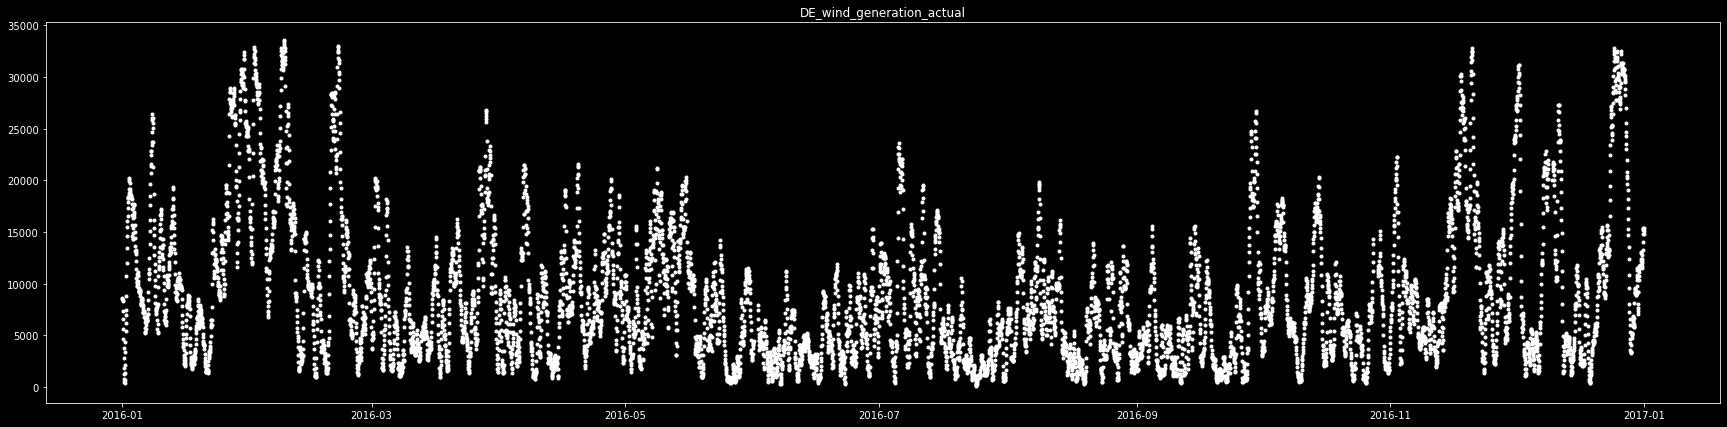

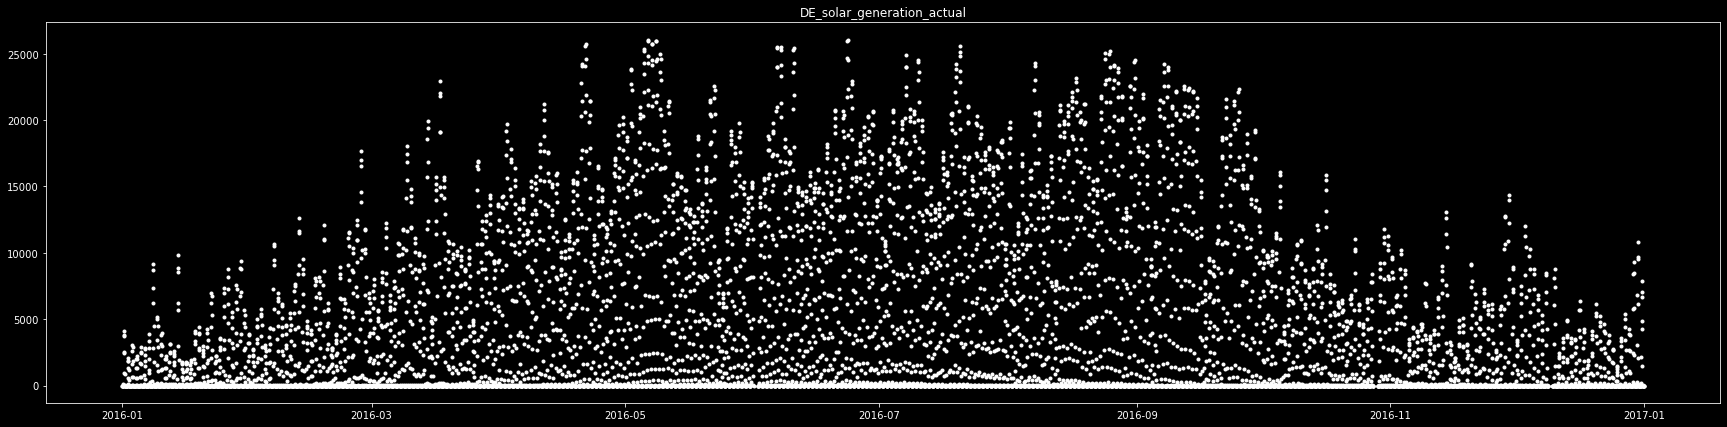

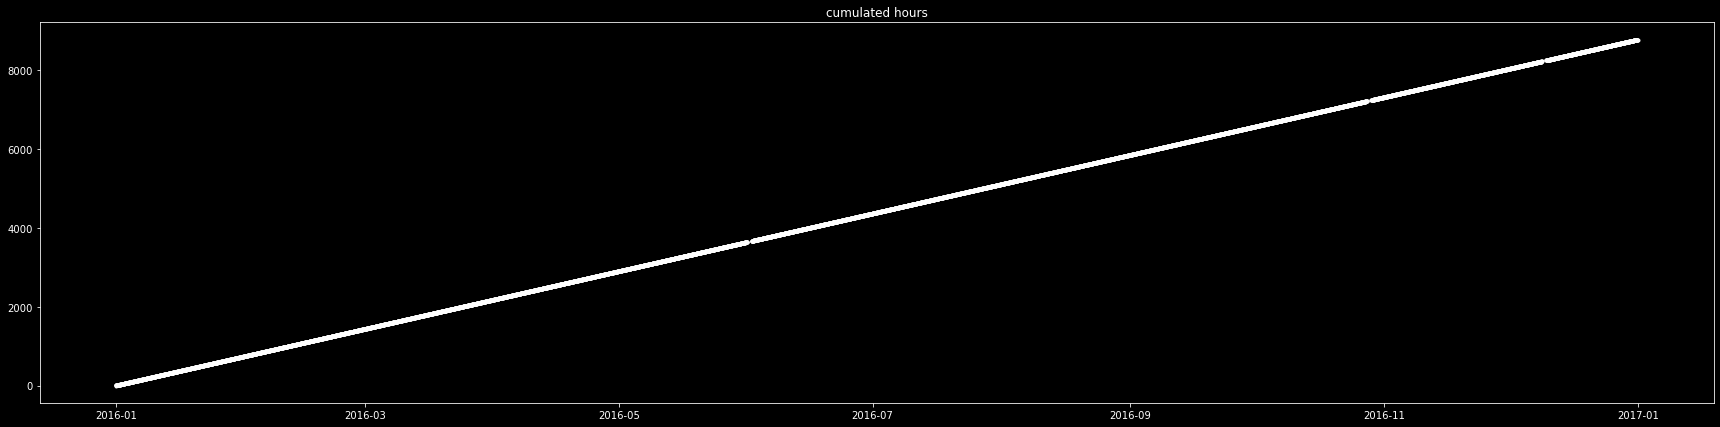

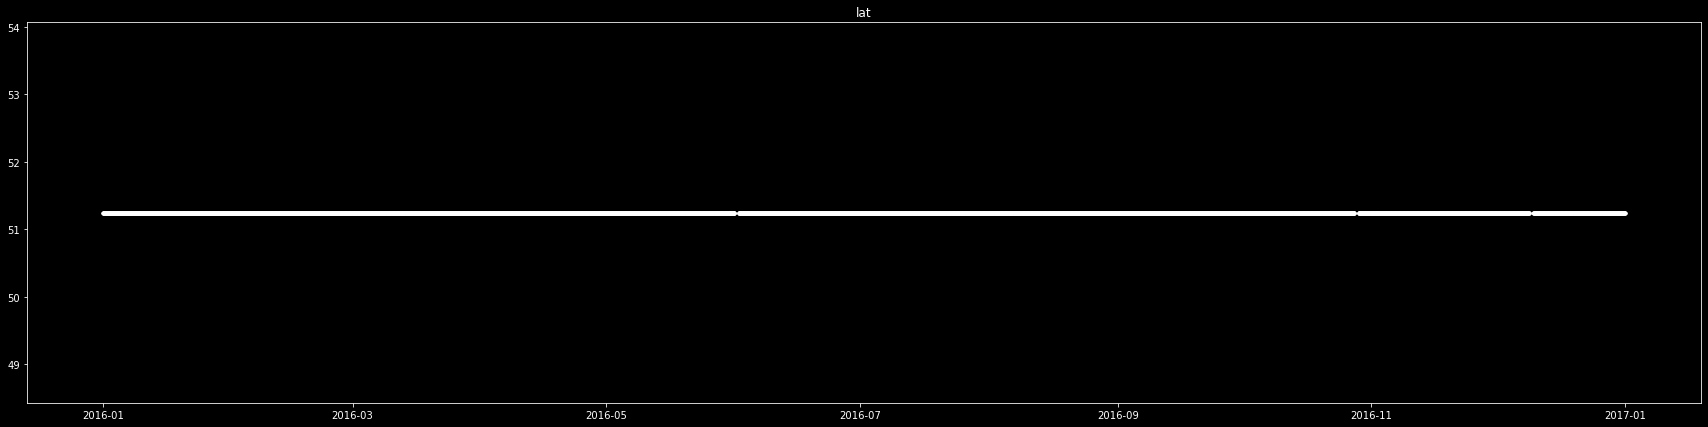

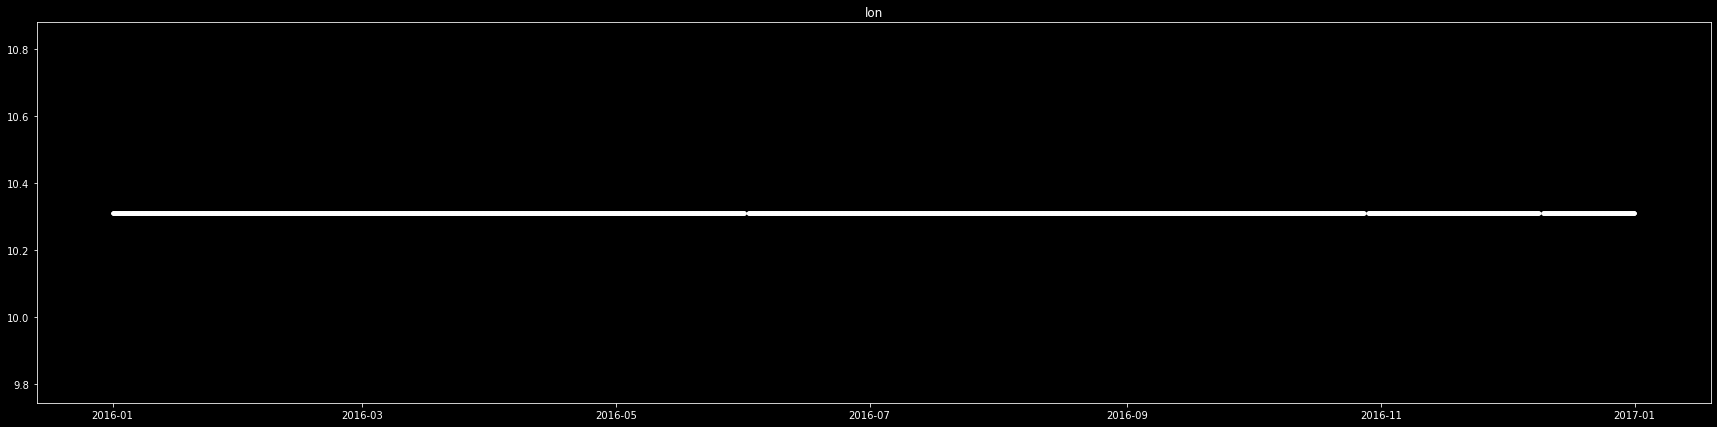

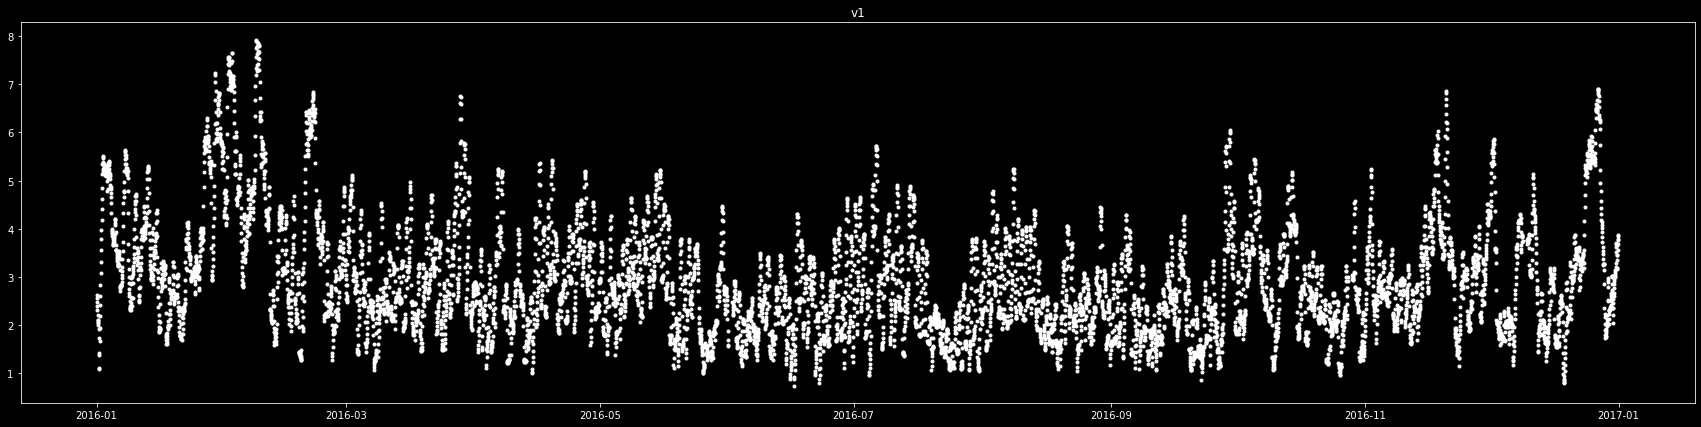

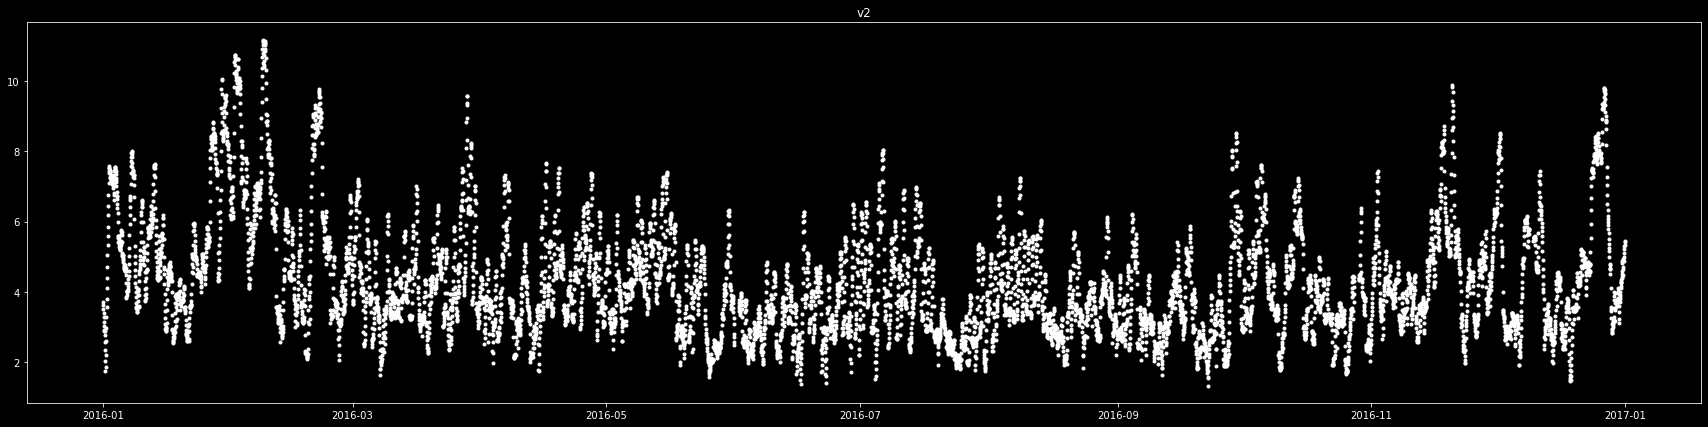

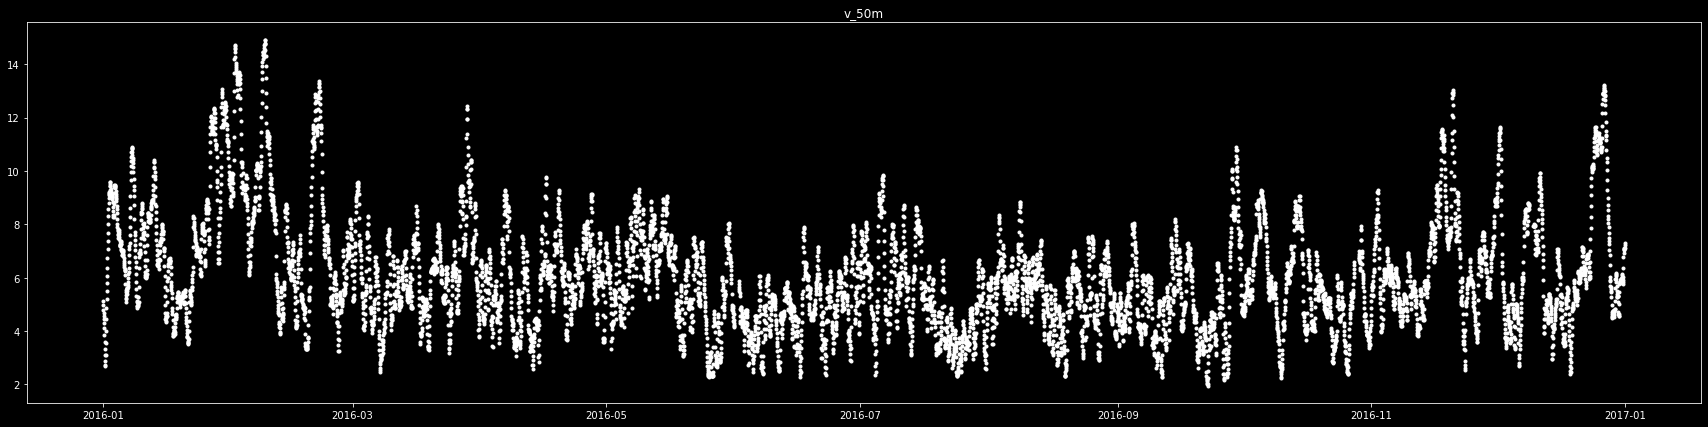

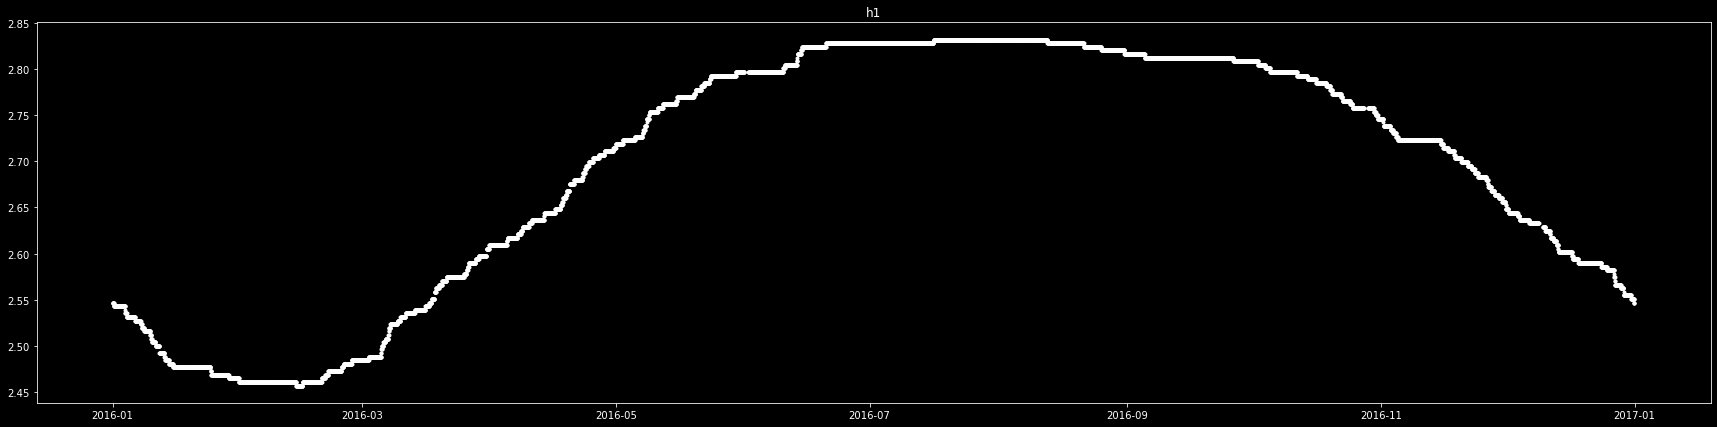

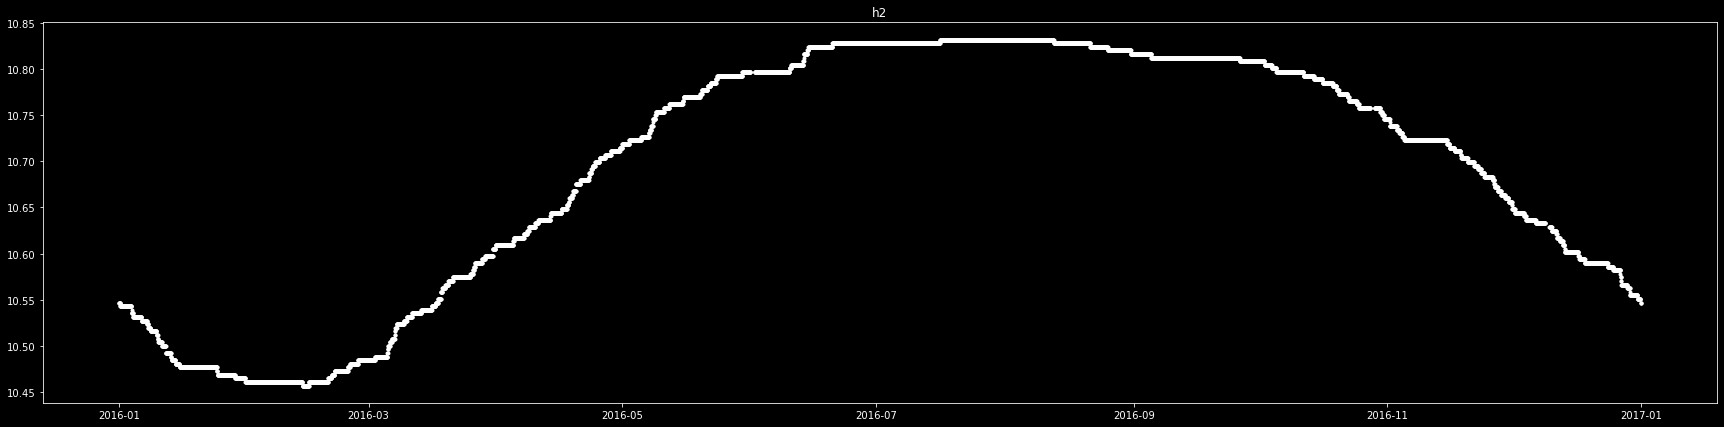

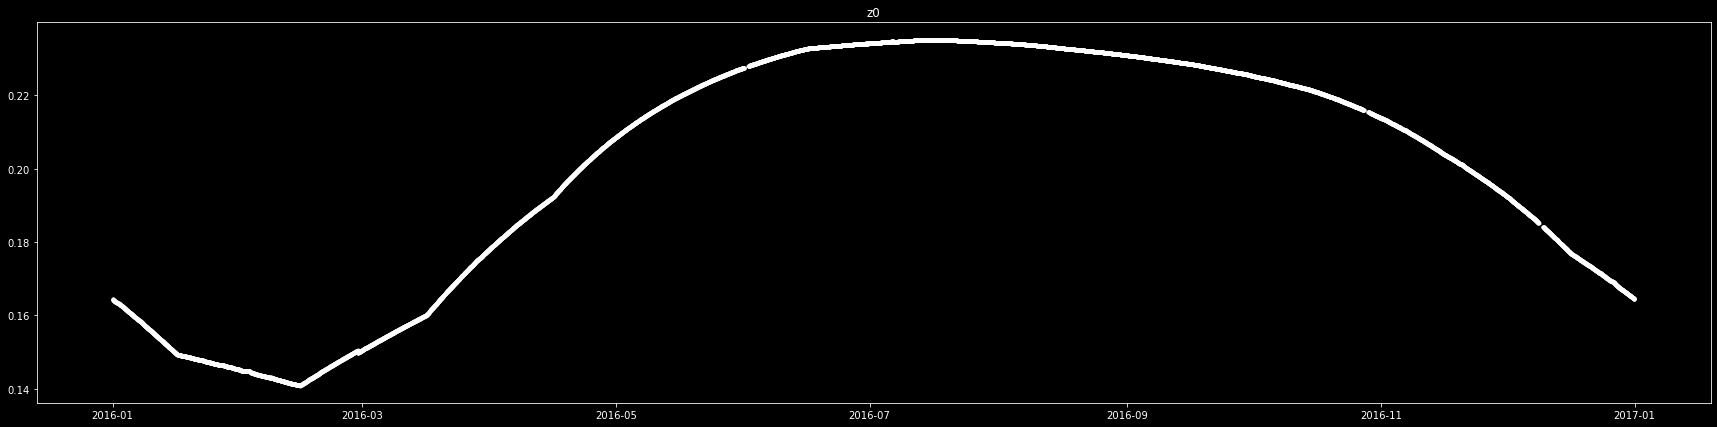

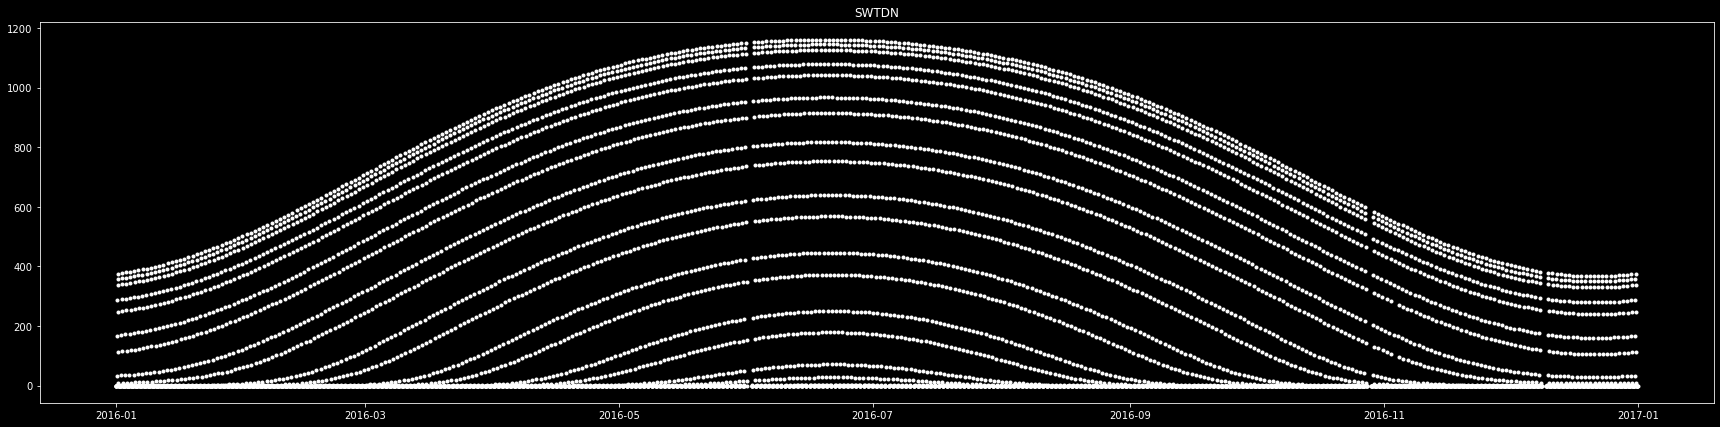

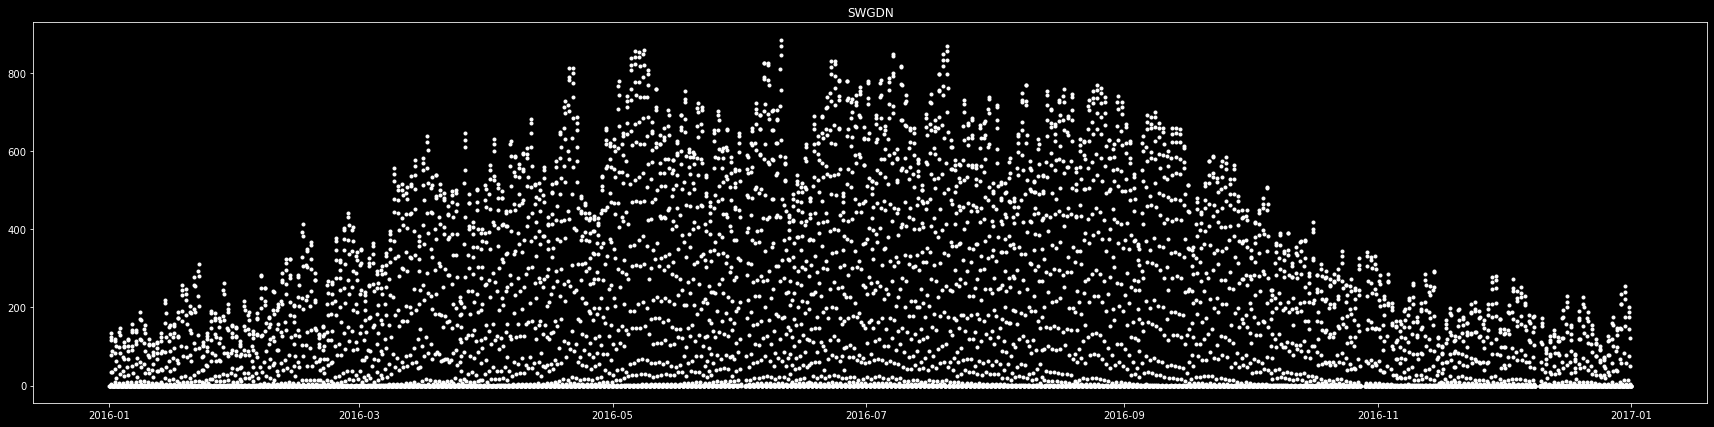

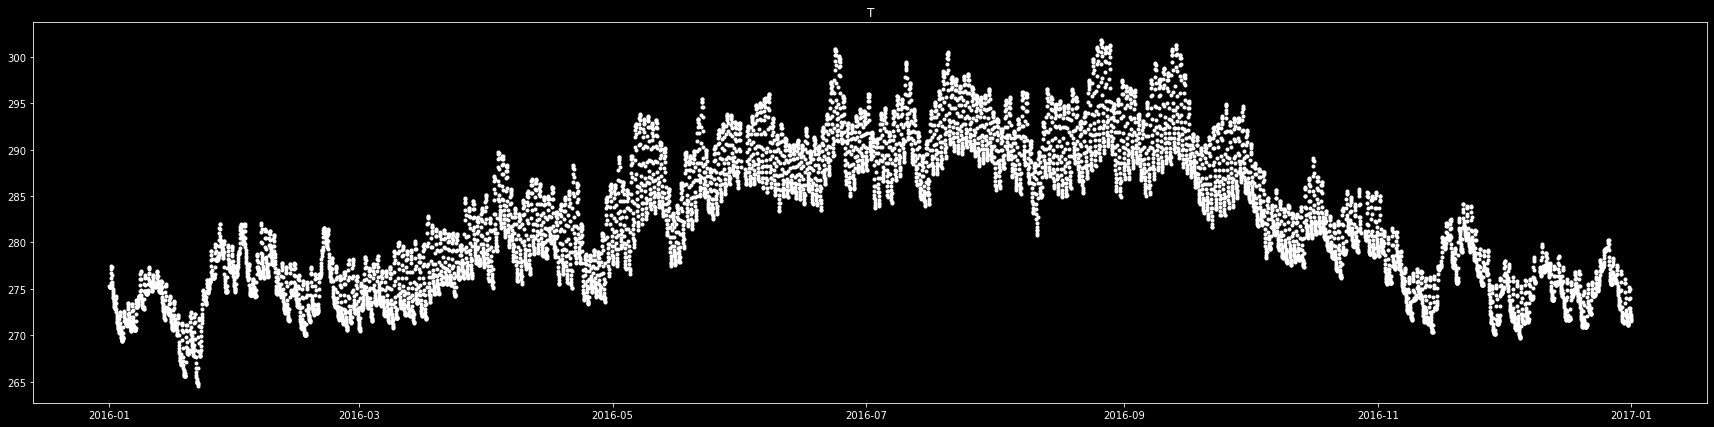

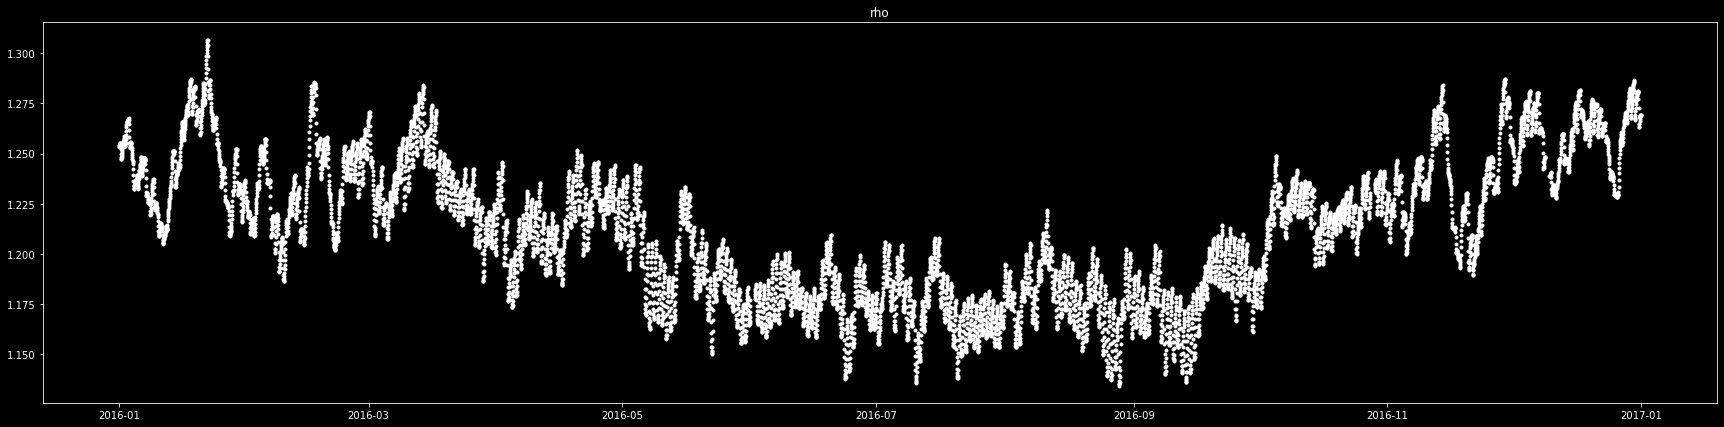

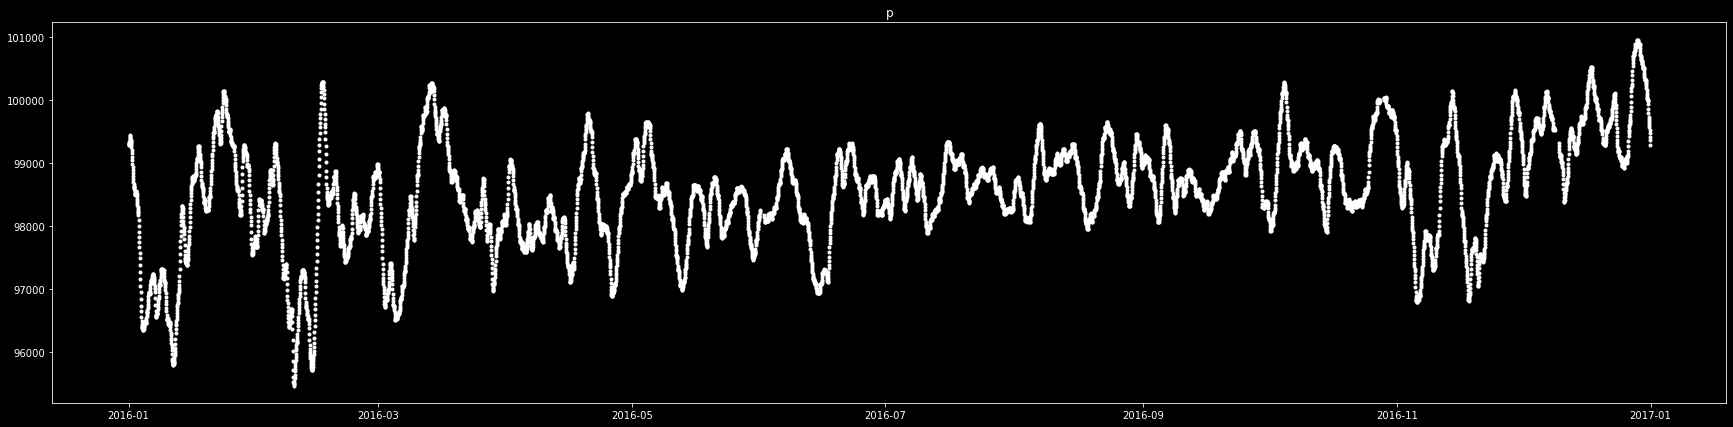

In [283]:
for col in df.columns:
    plt.figure(figsize=[30,7])
    plt.plot(df[col], '.', color='w')
    plt.title(col)
    plt.show()

In [285]:
print(df.shape)

(8710, 16)


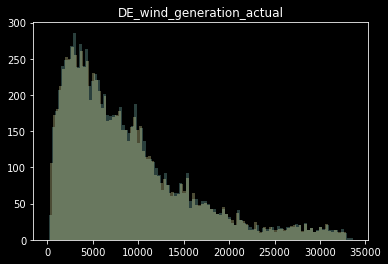

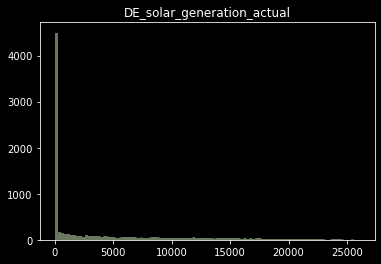

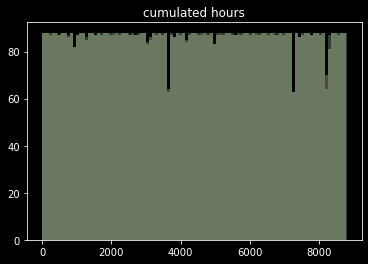

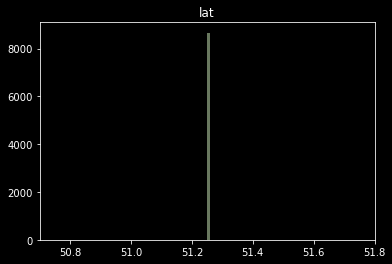

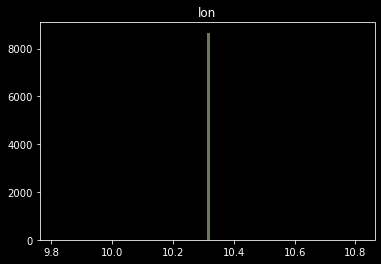

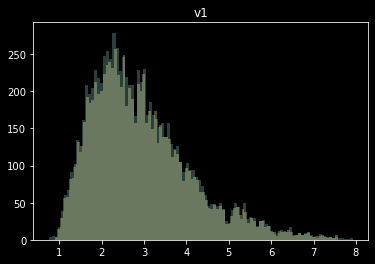

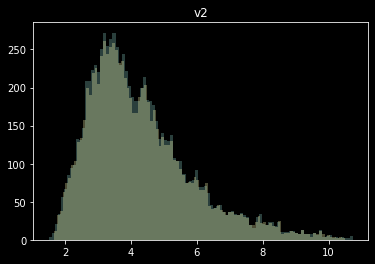

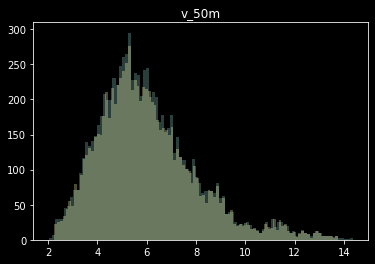

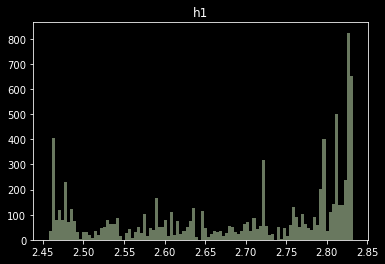

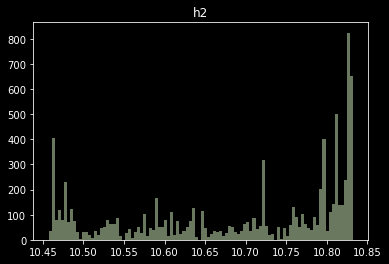

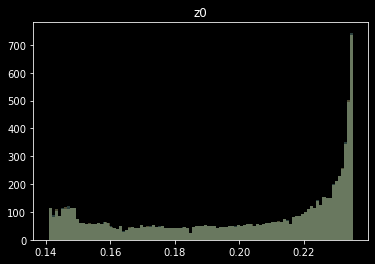

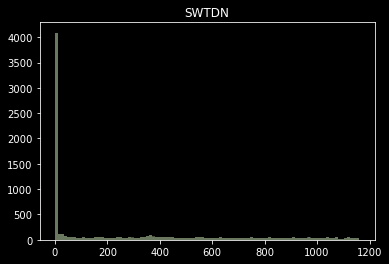

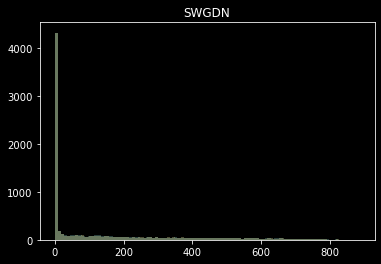

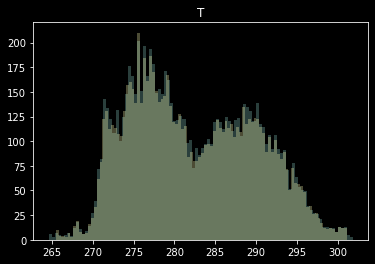

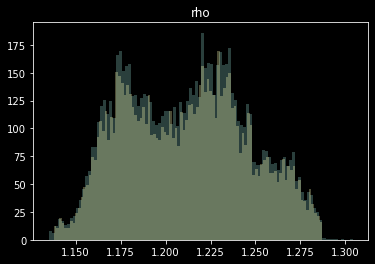

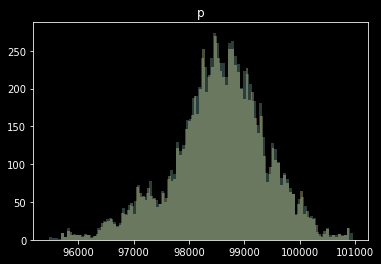

In [286]:
for col in df.columns:
    q1 = df[col].quantile(0.001)
    q2 = df[col].quantile(0.999)
    plt.hist(df[col], bins=100, alpha=0.3)
    plt.hist(df[df[col].between(q1,q2)][col], bins=100, alpha=0.3)
    plt.title(col)
    plt.show()
    df = df[df[col].between(q1,q2)]

In [287]:
print(df.shape)

(8521, 16)


## EDA:

#### Add some time-dependent features

In [302]:
def create_time_features(df):
    df['timestamp'] = pd.to_datetime(df.index)
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['month'] = df['timestamp'].dt.month
    return df

df = create_time_features(df)

### Check correlations:

In [303]:
df.phik_matrix()

interval columns not set, guessing: ['DE_wind_generation_actual', 'DE_solar_generation_actual', 'cumulated hours', 'lat', 'lon', 'v1', 'v2', 'v_50m', 'h1', 'h2', 'z0', 'SWTDN', 'SWGDN', 'T', 'rho', 'p', 'hour', 'day_of_week', 'month', 'day_of_year']


,DE_wind_generation_actual,DE_solar_generation_actual,cumulated hours,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p,timestamp,hour,day_of_week,month,day_of_year
DE_wind_generation_actual,1.000000,0.207335,0.449393,0.855116,0.881023,0.925390,0.442218,0.442218,0.466018,0.187664,0.209466,0.410123,0.346916,0.330384,1.0,0.116788,0.446163,0.457754,0.446163
DE_solar_generation_actual,0.207335,1.000000,0.397990,0.312770,0.218249,0.251261,0.293068,0.293068,0.315625,0.860398,0.927146,0.605498,0.449826,0.201021,1.0,0.704324,0.397320,0.395483,0.397320
cumulated hours,0.449393,0.397990,1.000000,0.444696,0.453867,0.470679,0.925094,0.925094,0.933175,0.492386,0.431857,0.797454,0.779811,0.681799,1.0,0.000000,0.999987,0.981835,0.999987
v1,0.855116,0.312770,0.444696,1.000000,0.990101,0.918493,0.456366,0.456366,0.479335,0.327412,0.313856,0.375043,0.363074,0.328893,1.0,0.371036,0.441715,0.448203,0.441715
v2,0.881023,0.218249,0.453867,0.990101,1.000000,0.942406,0.470927,0.470927,0.490564,0.217210,0.204952,0.389881,0.379239,0.353494,1.0,0.270746,0.450856,0.463629,0.450856
v_50m,0.925390,0.251261,0.470679,0.918493,0.942406,1.000000,0.483359,0.483359,0.501205,0.236145,0.249831,0.440081,0.379721,0.358072,1.0,0.183193,0.468443,0.493946,0.468443
h1,0.442218,0.293068,0.925094,0.456366,0.470927,0.483359,1.000000,1.000000,0.987736,0.341938,0.313077,0.763235,0.737425,0.679805,1.0,0.000000,0.925626,0.930550,0.925626
h2,0.442218,0.293068,0.925094,0.456366,0.470927,0.483359,1.000000,1.000000,0.987736,0.341938,0.313077,0.763235,0.737425,0.679805,1.0,0.000000,0.925626,0.930550,0.925626
z0,0.466018,0.315625,0.933175,0.479335,0.490564,0.501205,0.987736,0.987736,1.000000,0.358680,0.326254,0.782762,0.747853,0.629272,1.0,0.000000,0.933276,0.938714,0.933276
SWTDN,0.187664,0.860398,0.492386,0.327412,0.217210,0.236145,0.341938,0.341938,0.358680,1.000000,0.913644,0.560970,0.442331,0.187936,1.0,0.764804,0.491758,0.490079,0.491758


In [289]:
df.significance_matrix()

interval columns not set, guessing: ['DE_wind_generation_actual', 'DE_solar_generation_actual', 'cumulated hours', 'lat', 'lon', 'v1', 'v2', 'v_50m', 'h1', 'h2', 'z0', 'SWTDN', 'SWGDN', 'T', 'rho', 'p']


,DE_wind_generation_actual,DE_solar_generation_actual,cumulated hours,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
DE_wind_generation_actual,178.196478,14.570962,39.842922,98.788065,108.079716,125.003645,37.497953,37.499717,39.908938,13.493151,15.364520,35.553511,28.985096,24.877176
DE_solar_generation_actual,14.570962,152.085698,36.143958,25.413871,14.833477,18.053373,24.762224,24.732717,26.424085,111.336798,121.257753,52.594339,35.831661,15.885225
cumulated hours,39.842922,36.143958,196.568215,37.856170,38.891351,41.610251,143.897097,143.896061,147.222291,48.545565,41.952292,104.032076,98.703937,70.021785
v1,98.788065,25.413871,37.856170,178.655654,148.338241,107.957553,38.418081,38.385038,40.099011,26.652600,25.328832,31.853848,30.242720,25.377738
v2,108.079716,14.833477,38.891351,148.338241,178.251463,119.123006,40.295030,40.285526,41.904950,14.867518,14.002072,33.168341,31.427563,27.626661
v_50m,125.003645,18.053373,41.610251,107.957553,119.123006,178.578887,42.262187,42.260404,43.181610,17.459870,18.286683,37.960625,31.992170,27.602090
h1,37.497953,24.762224,143.897097,38.418081,40.295030,42.262187,182.588779,182.585345,163.903196,31.668131,27.735822,96.642220,89.544269,59.323872
h2,37.499717,24.732717,143.896061,38.385038,40.285526,42.260404,182.585345,182.598644,163.905015,31.642721,27.757402,96.635255,89.553184,59.331307
z0,39.908938,26.424085,147.222291,40.099011,41.904950,43.181610,163.903196,163.905015,185.320784,33.062295,28.466751,101.571236,94.325304,55.385526
SWTDN,13.493151,111.336798,48.545565,26.652600,14.867518,17.459870,31.668131,31.642721,33.062295,167.451720,124.755156,53.722340,39.282198,14.994568


So from phik-correlation martix we can choose features for wind and solar. Let's keep on with features demonstrate more than 0.5 correlation with wind (DE_wind_generation_actual) or solar (DE_solar_generation_actual) production and divide datasets for train and test:

In [304]:
wind_features = ['v1', 'v2', 'v_50m']
solar_features = ['SWTDN', 'SWGDN', 'T', 'hour']
wind_target = 'DE_wind_generation_actual'
solar_target = 'DE_solar_generation_actual'

df_wind = df[wind_features + [wind_target]].copy()
df_solar = df[solar_features + [solar_target]].copy()

wind_train, wind_test = train_test_split(df_wind, train_size=0.75,random_state=42)
solar_train, solar_test = train_test_split(df_solar, train_size=0.75,random_state=42)

print(wind_test.shape[0] / df_wind.shape[0])

0.2500880178382819


### Let's try to make clusterization and add some cluster-feature to our dataset:

In [291]:
def get_cluster_feature(train, test, eps=0.1, min_samples=7):
    scaler = StandardScaler()
    X = scaler.fit_transform(train)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)

    # Find the core samples used by DBSCAN
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    # Remove noise points from the original dataset
    X_core = X[core_samples_mask]
    y_core = dbscan.labels_[core_samples_mask]

    # Train a KNeighborsClassifier on the core samples
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_core, y_core)

    X_new = scaler.transform(test)
    new_labels = knn.predict(X_new)

    return new_labels

In [292]:
train_labels = get_cluster_feature(wind_train, wind_train)
test_labels = get_cluster_feature(wind_train, wind_test)
wind_train.loc[:,'cluster'] = train_labels
wind_test.loc[:,'cluster'] = test_labels

train_labels = get_cluster_feature(solar_train, solar_train, eps=0.2, min_samples=7)
test_labels = get_cluster_feature(solar_train, solar_test, eps=0.2, min_samples=7)
solar_train.loc[:,'cluster'] = train_labels
solar_test.loc[:,'cluster'] = test_labels

### Next write the function to fit a model and use optuna to find optimal catboost parameters:

0:	learn: 4516.2500235	test: 4655.3814092	best: 4655.3814092 (0)	total: 6.21ms	remaining: 6.21s
100:	learn: 1061.0339327	test: 1118.7366202	best: 1118.7366202 (100)	total: 139ms	remaining: 1.23s
200:	learn: 983.1350254	test: 1077.2183280	best: 1077.2183280 (200)	total: 264ms	remaining: 1.05s
300:	learn: 940.3443951	test: 1059.8930078	best: 1059.8863065 (298)	total: 389ms	remaining: 903ms
400:	learn: 907.7080561	test: 1052.1494652	best: 1052.1494652 (400)	total: 513ms	remaining: 767ms
500:	learn: 887.8463632	test: 1047.5569568	best: 1047.5569568 (500)	total: 637ms	remaining: 635ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1045.336834
bestIteration = 544

Shrink model to first 545 iterations.


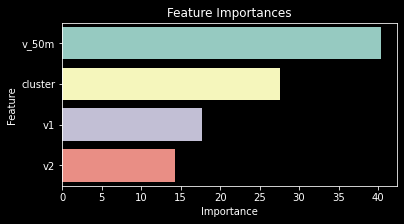

[I 2023-04-27 16:22:52,680] A new study created in memory with name: no-name-c321abf6-c255-44ef-b338-c6d180c411e0
[I 2023-04-27 16:22:54,775] Trial 0 finished with value: 1138.0812273556137 and parameters: {'iterations': 1079, 'depth': 8, 'learning_rate': 0.004619444939234517, 'l2_leaf_reg': 0.2420190717216813}. Best is trial 0 with value: 1138.0812273556137.
[I 2023-04-27 16:22:55,036] Trial 1 finished with value: 1145.530947621091 and parameters: {'iterations': 227, 'depth': 5, 'learning_rate': 0.036184322679250605, 'l2_leaf_reg': 0.12478169183057894}. Best is trial 0 with value: 1138.0812273556137.
[I 2023-04-27 16:22:56,677] Trial 2 finished with value: 1046.7731065344349 and parameters: {'iterations': 1098, 'depth': 10, 'learning_rate': 0.055867230091050636, 'l2_leaf_reg': 0.00026850204425314943}. Best is trial 2 with value: 1046.7731065344349.
[I 2023-04-27 16:22:57,270] Trial 3 finished with value: 1060.0949330490312 and parameters: {'iterations': 1353, 'depth': 4, 'learning_rat

Best hyperparameters: {'iterations': 1613, 'depth': 9, 'learning_rate': 0.043612783049771536, 'l2_leaf_reg': 0.002251766642473486}
0:	learn: 4772.2478985	test: 4917.3663289	best: 4917.3663289 (0)	total: 2.32ms	remaining: 3.74s
100:	learn: 1084.3362673	test: 1143.4074351	best: 1143.4074351 (100)	total: 242ms	remaining: 3.62s
200:	learn: 1016.6291953	test: 1085.2007695	best: 1085.2007695 (200)	total: 482ms	remaining: 3.39s
300:	learn: 969.6724656	test: 1064.7963994	best: 1064.7963994 (300)	total: 723ms	remaining: 3.15s
400:	learn: 932.5982596	test: 1054.9427014	best: 1054.9427014 (400)	total: 964ms	remaining: 2.91s
500:	learn: 903.4383762	test: 1048.0594827	best: 1048.0594827 (500)	total: 1.21s	remaining: 2.68s
600:	learn: 878.2204200	test: 1043.6714188	best: 1043.6714188 (600)	total: 1.45s	remaining: 2.44s
700:	learn: 857.0232736	test: 1040.5670653	best: 1040.5670653 (700)	total: 1.69s	remaining: 2.2s
800:	learn: 838.0585146	test: 1039.0679457	best: 1039.0679457 (800)	total: 1.93s	remai

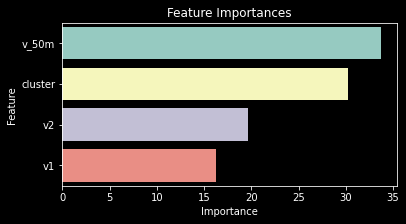

In [293]:
def objective(trial, train_pool, test_pool, test, target):
    # Suggest hyperparameters using Optuna's API
    iterations = trial.suggest_int("iterations", 100, 2000)
    depth = trial.suggest_int("depth", 4, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1, log=True)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-4, 10, log=True)

    # Train the CatBoost model
    model = CatBoostRegressor(iterations=iterations, depth=depth, learning_rate=learning_rate, l2_leaf_reg=l2_leaf_reg,
                            loss_function='MAE', random_seed=42, verbose=False)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

    # Calculate an error
    test_preds = model.predict(test_pool)
    test_err = np.mean(np.abs(test[target] - test_preds))

    return test_err

def fit_model(train, test, features, target, learning_rate=0.1):
    # Create CatBoost datasets
    train_pool = Pool(train[features], train[target])
    test_pool = Pool(test[features], test[target])

    # Fit the CatBoost model
    model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=learning_rate, loss_function='MAE', random_seed=42, verbose=100)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

    # Get feature importances
    feature_importances = model.get_feature_importance(train_pool)
    importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

    # Plot feature importances
    plt.figure(figsize=(6, 3))
    sns.barplot(x='importance', y='feature', data=importance_df.sort_values('importance', ascending=False))
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, train_pool, test_pool, test, target), n_trials=50)
    print("Best hyperparameters:", study.best_params)
    best_params = study.best_params
    best_model = CatBoostRegressor(**best_params, loss_function='MAE', random_seed=42, verbose=100)
    best_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

    # Get feature importances
    feature_importances = best_model.get_feature_importance(train_pool)
    importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

    # Plot feature importances
    plt.figure(figsize=(6, 3))
    sns.barplot(x='importance', y='feature', data=importance_df.sort_values('importance', ascending=False))
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    return best_model

wind_features_exp = wind_features + ['cluster']
wind_model = fit_model(wind_train, wind_test, wind_features_exp, wind_target)

0:	learn: 3747.7413044	test: 3626.2202182	best: 3626.2202182 (0)	total: 2.03ms	remaining: 2.02s
100:	learn: 599.3067453	test: 579.9311811	best: 579.9311811 (100)	total: 151ms	remaining: 1.34s
200:	learn: 544.7567934	test: 533.1120353	best: 533.1120353 (200)	total: 284ms	remaining: 1.13s
300:	learn: 499.0660029	test: 497.5051149	best: 497.5051149 (300)	total: 421ms	remaining: 977ms
400:	learn: 466.2032357	test: 480.2274432	best: 480.2274432 (400)	total: 555ms	remaining: 829ms
500:	learn: 442.0881527	test: 467.5239640	best: 467.4883329 (499)	total: 693ms	remaining: 690ms
600:	learn: 410.1278719	test: 450.7760249	best: 450.7664016 (599)	total: 829ms	remaining: 550ms
700:	learn: 392.2130474	test: 443.9881359	best: 443.9881359 (700)	total: 968ms	remaining: 413ms
800:	learn: 376.8896191	test: 439.5750947	best: 439.5750947 (800)	total: 1.1s	remaining: 275ms
900:	learn: 365.5681776	test: 437.0944601	best: 437.0944601 (900)	total: 1.24s	remaining: 136ms
999:	learn: 357.9018672	test: 434.9602890

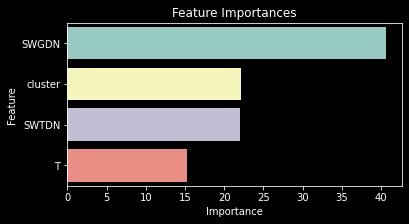

[I 2023-04-27 16:24:37,517] A new study created in memory with name: no-name-a860a1e1-10e6-454a-960a-eb990a69adb5
[I 2023-04-27 16:24:39,183] Trial 0 finished with value: 515.2221191119467 and parameters: {'iterations': 1308, 'depth': 5, 'learning_rate': 0.009895981730229661, 'l2_leaf_reg': 0.0007423249468583914}. Best is trial 0 with value: 515.2221191119467.
[I 2023-04-27 16:24:39,705] Trial 1 finished with value: 3638.1004859161962 and parameters: {'iterations': 227, 'depth': 8, 'learning_rate': 0.00017376953971425587, 'l2_leaf_reg': 0.0003436668519793671}. Best is trial 0 with value: 515.2221191119467.
[I 2023-04-27 16:24:45,792] Trial 2 finished with value: 2415.369309262297 and parameters: {'iterations': 1808, 'depth': 10, 'learning_rate': 0.00026347897084004967, 'l2_leaf_reg': 1.6429105233112868}. Best is trial 0 with value: 515.2221191119467.
[I 2023-04-27 16:24:47,059] Trial 3 finished with value: 1133.6943627985756 and parameters: {'iterations': 694, 'depth': 7, 'learning_rat

Best hyperparameters: {'iterations': 1477, 'depth': 9, 'learning_rate': 0.06196661047016843, 'l2_leaf_reg': 0.010655181570758777}
0:	learn: 3661.6675664	test: 3542.9147053	best: 3542.9147053 (0)	total: 2.73ms	remaining: 4.04s
100:	learn: 512.4804188	test: 505.8779409	best: 505.8779409 (100)	total: 254ms	remaining: 3.46s
200:	learn: 431.8807847	test: 451.4636161	best: 451.4636161 (200)	total: 500ms	remaining: 3.17s
300:	learn: 388.9238458	test: 437.1311805	best: 437.1311805 (300)	total: 748ms	remaining: 2.92s
400:	learn: 340.5079039	test: 422.7465630	best: 422.7465630 (400)	total: 1s	remaining: 2.68s
500:	learn: 315.2111845	test: 417.7963271	best: 417.6523168 (499)	total: 1.24s	remaining: 2.42s
600:	learn: 291.9600281	test: 413.8262370	best: 413.8262370 (600)	total: 1.49s	remaining: 2.17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 413.0029245
bestIteration = 634

Shrink model to first 635 iterations.


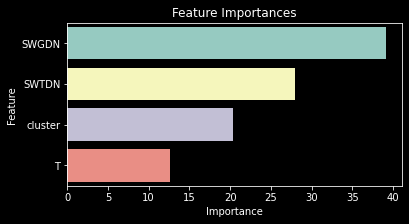

In [294]:
solar_features_exp = solar_features + ['cluster']
solar_model = fit_model(solar_train, solar_test, solar_features_exp, solar_target, learning_rate=0.04)